In [1]:
import os
os.environ['USE_PYGEOS'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
#import geojsonio
import geopandas as gpd
import fiona
import pyproj
import osm2geojson
import fiona
import shapely
#import swifter

#install pygeos=0.14
#install geopandas=0.12
#to run Notebook, use anaconda enviroment, install all above dependencies with conda
#osm2geojson can be installed with pip

agg_times = True
agg_period = '6H'

C:\Users\Duxiangyu\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [37]:
# def save_as_geojson(df, name='geojson_test'):
#     geo = gpd.GeoDataFrame(df,geometry=df['geometry'].apply(shapely.geometry.shape), crs={'init':'EPSG:4326'})
#     #final_geo['datetime'] = final_geo['datetime'].astype(str)
#     with open(f"{name}.geojson", "w", encoding="utf-8") as outfile:
#         outfile.write(geo.to_json())

### Load data

In [2]:
strava = pd.read_csv('strava_january.csv')
paths = pd.read_csv('counter_osm_id.csv')
bikes = pd.read_csv('bike_counters_full.csv')
weather = pd.read_csv('weatherdata.csv')

bounding_box = (4.8151, 5.0228, 52.3263, 52.4200)
ams_map = plt.imread('map.png')

with open('locations_bike_counters.geojson', 'r') as f:
    bike_locations = json.load(f)['features']
with open('traffic_speed_v2.geojson', 'r') as f:
    traffic_speed_json = json.load(f)['features']

bike_locations = list(map(lambda x: x['properties'],bike_locations))
bike_locations = pd.DataFrame.from_dict(bike_locations)

bikes['datetime'] = pd.to_datetime(bikes['datetime'], infer_datetime_format=True)
strava['hour'] = pd.to_datetime(strava['hour'], infer_datetime_format=True)

bikes

,Unnamed: 0,location,latitude,longitude,plusdirection,mindirection,direction,datetime,count,speed_mean
0,0,De Boelelaan,52.334960,4.883243,Antonio Vivaldistraat richting Beethovenstraat,Beethovenstraat richting Antonio Vivaldistraat,-1,2021-05-05 15:00:00,4,16.00
1,1,De Boelelaan,52.334960,4.883243,Antonio Vivaldistraat richting Beethovenstraat,Beethovenstraat richting Antonio Vivaldistraat,1,2021-05-05 15:00:00,20,15.00
2,2,De Boelelaan,52.334960,4.883243,Antonio Vivaldistraat richting Beethovenstraat,Beethovenstraat richting Antonio Vivaldistraat,-1,2021-05-05 16:00:00,4,17.75
3,3,De Boelelaan,52.334960,4.883243,Antonio Vivaldistraat richting Beethovenstraat,Beethovenstraat richting Antonio Vivaldistraat,1,2021-05-05 16:00:00,52,16.29
4,4,De Boelelaan,52.334960,4.883243,Antonio Vivaldistraat richting Beethovenstraat,Beethovenstraat richting Antonio Vivaldistraat,-1,2021-05-05 17:00:00,12,17.33
...,...,...,...,...,...,...,...,...,...,...
684409,684409,Zuiderzeeweg,52.370356,4.962579,Zeeburgerdijk richting Ijburglaan,Ijburglaan richting Zeeburgerdijk,-1,2022-06-02 18:00:00,1,16.00
684410,684410,Zuiderzeeweg,52.370356,4.962579,Zeeburgerdijk richting Ijburglaan,Ijburglaan richting Zeeburgerdijk,1,2022-06-02 18:00:00,48,23.62
684411,684411,Zuiderzeeweg,52.370356,4.962579,Zeeburgerdijk richting Ijburglaan,Ijburglaan richting Zeeburgerdijk,1,2022-06-02 19:00:00,0,NaN
684412,684412,Zuiderzeeweg,52.370356,4.962579,Zeeburgerdijk richting Ijburglaan,Ijburglaan richting Zeeburgerdijk,1,2022-06-02 20:00:00,0,NaN


In [39]:
strava_unique = list(strava['osm_reference_id'].unique())
len(strava_unique)

13998

### Call open street map to get locations of strava streets

In [40]:
#states = gpd.read_file('traffic_speed.geojson')
osm_result = None
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
ways = ','.join([str(i) for i in strava_unique])
#osm_result = overpass.query(f'way(id:{ways});out geom;')
#save = osm_result.toJSON()

#with open("strava_download.json", "w", encoding="utf-8") as outfile:
    #outfile.write(json.dumps(save))

In [41]:
if osm_result is not None:
    osm_ways = osm_result.toJSON()
    with open("strava_download.geojson", "w", encoding="utf-8") as outfile:
        t = json.dumps(osm2geojson.json2geojson(osm_ways))
        outfile.write(t)

In [42]:
with open('strava_download.geojson', 'r') as f:
    osm_ways = json.load(f)['features']
#osm_ways

### Create a df of open street map streets

In [43]:
out_list = []
for el in osm_ways:
    props = el['properties']
    geo = el['geometry']
    if 'tags' in props and 'name' in props['tags']:
        tmp = {'name':props['tags']['name'], 'osm_reference_id':props['id'], 'extra':props['tags'], 'geometry':geo}
        out_list.append(tmp)
strava_name_id = pd.DataFrame.from_dict(out_list)
strava_name_id

,name,osm_reference_id,extra,geometry
0,Vondelpark,4277440,"{'bicycle': 'yes', 'foot': 'yes', 'highway': '...","{'type': 'LineString', 'coordinates': [[4.8814..."
1,Kattenburgerplein,4363637,"{'highway': 'cycleway', 'lit': 'yes', 'lit:ind...","{'type': 'LineString', 'coordinates': [[4.9153..."
2,Bruno van Moerkerkenpassage,4364568,"{'bicycle': 'designated', 'description': 'Fiet...","{'type': 'LineString', 'coordinates': [[4.9119..."
3,Kattenburgerplein,4371501,"{'highway': 'cycleway', 'lit': 'yes', 'mofa': ...","{'type': 'LineString', 'coordinates': [[4.9153..."
4,Vondelpark,4480497,"{'bicycle': 'yes', 'foot': 'yes', 'highway': '...","{'type': 'LineString', 'coordinates': [[4.8570..."
...,...,...,...,...
6986,Zekeringstraat,1014623597,"{'cycleway': 'lane', 'highway': 'tertiary', 'l...","{'type': 'LineString', 'coordinates': [[4.8476..."
6987,Oeverzeggestraat,1019476368,"{'footway': 'sidewalk', 'highway': 'cycleway',...","{'type': 'LineString', 'coordinates': [[4.9868..."
6988,Prins Hendrikkade,1020011232,"{'bicycle': 'use_sidepath', 'bridge': 'yes', '...","{'type': 'LineString', 'coordinates': [[4.9034..."
6989,Haarlemmerweg,1020818640,"{'bicycle': 'use_sidepath', 'carriageway_ref':...","{'type': 'LineString', 'coordinates': [[4.8428..."


In [44]:
def is_separated(extra):
    for key, value in extra.items():
        if key == 'cycleway' and value == 'lane': return False
        elif key == 'highway' and value == 'cycleway': return True
        elif key == 'highway' and value == 'pedestrian': return True
        elif key == 'bicycle' and value == 'use_sidepath': return True
        elif key == 'bicycle' and value == 'designated': return True
    return False
strava_name_id['separated'] = strava_name_id['extra'].apply(is_separated) 
#strava_name_id = strava_name_id[['name','osm_reference_id', 'separated', 'geometry']]
strava_name_id = strava_name_id[~strava_name_id['geometry'].astype(str).str.startswith('POLY')]
#save_as_geojson(strava_name_id)
strava_name_id

,name,osm_reference_id,extra,geometry,separated
0,Vondelpark,4277440,"{'bicycle': 'yes', 'foot': 'yes', 'highway': '...","{'type': 'LineString', 'coordinates': [[4.8814...",True
1,Kattenburgerplein,4363637,"{'highway': 'cycleway', 'lit': 'yes', 'lit:ind...","{'type': 'LineString', 'coordinates': [[4.9153...",True
2,Bruno van Moerkerkenpassage,4364568,"{'bicycle': 'designated', 'description': 'Fiet...","{'type': 'LineString', 'coordinates': [[4.9119...",True
3,Kattenburgerplein,4371501,"{'highway': 'cycleway', 'lit': 'yes', 'mofa': ...","{'type': 'LineString', 'coordinates': [[4.9153...",True
4,Vondelpark,4480497,"{'bicycle': 'yes', 'foot': 'yes', 'highway': '...","{'type': 'LineString', 'coordinates': [[4.8570...",True
...,...,...,...,...,...
6986,Zekeringstraat,1014623597,"{'cycleway': 'lane', 'highway': 'tertiary', 'l...","{'type': 'LineString', 'coordinates': [[4.8476...",False
6987,Oeverzeggestraat,1019476368,"{'footway': 'sidewalk', 'highway': 'cycleway',...","{'type': 'LineString', 'coordinates': [[4.9868...",True
6988,Prins Hendrikkade,1020011232,"{'bicycle': 'use_sidepath', 'bridge': 'yes', '...","{'type': 'LineString', 'coordinates': [[4.9034...",True
6989,Haarlemmerweg,1020818640,"{'bicycle': 'use_sidepath', 'carriageway_ref':...","{'type': 'LineString', 'coordinates': [[4.8428...",True


### Get street info from tomtom geojson(name, id, geometry)

In [45]:
out_list = []

for el in traffic_speed_json:
    geo = el['geometry']
    if 'properties' in el and 'streetName' in el['properties']:
        tmp = {'name':el['properties']['streetName'], 'segmentId':el['properties']['segmentId'],
              'extra':el['properties'], 'geometry':el['geometry']}
        out_list.append(tmp)
#, 'speed': el['properties']['segmentTimeResults'][0]['averageSpeed']
traffic_speed = pd.DataFrame.from_dict(out_list)
#traffic_speed = traffic_speed.groupby(['name']).mean().reset_index(0)
traffic_speed

,name,segmentId,extra,geometry
0,Louis Couperusstraat,-15280001772950,"{'segmentId': -15280001772950, 'newSegmentId':...","{'type': 'LineString', 'coordinates': [[4.8292..."
1,Louis Couperusstraat,-15280000384709,"{'segmentId': -15280000384709, 'newSegmentId':...","{'type': 'LineString', 'coordinates': [[4.8313..."
2,Arthur van Schendelstraat,-15280000015541,"{'segmentId': -15280000015541, 'newSegmentId':...","{'type': 'LineString', 'coordinates': [[4.8303..."
3,Burgemeester Vening Meineszlaan,-15280000855390,"{'segmentId': -15280000855390, 'newSegmentId':...","{'type': 'LineString', 'coordinates': [[4.8335..."
4,Johan Herman Doornstraat,-15280000014851,"{'segmentId': -15280000014851, 'newSegmentId':...","{'type': 'LineString', 'coordinates': [[4.8324..."
...,...,...,...,...
20927,Distelweg,15280002438902,"{'segmentId': 15280002438902, 'newSegmentId': ...","{'type': 'LineString', 'coordinates': [[4.9020..."
20928,Johan van Hasseltweg,15280002231201,"{'segmentId': 15280002231201, 'newSegmentId': ...","{'type': 'LineString', 'coordinates': [[4.9144..."
20929,Werktuigstraat,15280002331943,"{'segmentId': 15280002331943, 'newSegmentId': ...","{'type': 'LineString', 'coordinates': [[4.8935..."
20930,Scheldeplein,15280002289116,"{'segmentId': 15280002289116, 'newSegmentId': ...","{'type': 'LineString', 'coordinates': [[4.8905..."


In [46]:
print(len(traffic_speed))
print(len(strava_name_id))

20932
6991


### Merge strava and tomtom streets based on distance

max distance of 10m used to prevent any far away merges

In [47]:
from shapely.geometry import Point, mapping, shape
from shapely.ops import nearest_points

def create_gdf(df):
    ret = gpd.GeoDataFrame(df, 
    geometry=df['geometry'].apply(shapely.geometry.shape), crs={'init':'EPSG:4326'})
    ret = ret.to_crs(crs=3857) 
    return ret 
stations_gdf = create_gdf(traffic_speed)#.iloc[:100]
points_gdf = create_gdf(strava_name_id)#.iloc[:100]

merged_strava_tom = gpd.sjoin_nearest(stations_gdf, points_gdf, max_distance=10, how='inner', lsuffix='tomtom',
                                      rsuffix='strava', distance_col='distance')
merged_strava_tom = merged_strava_tom.to_crs(crs=4326)
merged_strava_tom = merged_strava_tom.drop(columns=['index_strava'])
#merged_strava_tom = merged_strava_tom.drop(columns=['extra_tomtom','extra_strava'])
merged_strava_tom = merged_strava_tom[merged_strava_tom['name_tomtom'] == merged_strava_tom['name_strava']]

#with open("strava_tomtom_merged.geojson", "w", encoding="utf-8") as outfile:
#    outfile.write(merged_strava_tom.to_json())
merged_strava_tom
#merged_strava_tom[merged_strava_tom['name_tomtom'] != merged_strava_tom['name_strava']]['distance'].mean()
#22675

C:\Users\Duxiangyu\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name_tomtom,segmentId,extra_tomtom,geometry,name_strava,osm_reference_id,extra_strava,separated,distance
6,Burgemeester Fockstraat,-15280000018857,"{'segmentId': -15280000018857, 'newSegmentId':...","LINESTRING (4.83330 52.38231, 4.83354 52.38284)",Burgemeester Fockstraat,323258133,"{'bicycle': 'use_sidepath', 'highway': 'reside...",True,0.000000
3932,Burgemeester Fockstraat,-15280000592920,"{'segmentId': -15280000592920, 'newSegmentId':...","LINESTRING (4.83294 52.38144, 4.83304 52.38166)",Burgemeester Fockstraat,323258133,"{'bicycle': 'use_sidepath', 'highway': 'reside...",True,0.258764
3933,Burgemeester Fockstraat,-15280000200611,"{'segmentId': -15280000200611, 'newSegmentId':...","LINESTRING (4.83304 52.38166, 4.83313 52.38189)",Burgemeester Fockstraat,323258133,"{'bicycle': 'use_sidepath', 'highway': 'reside...",True,0.258764
3934,Burgemeester Fockstraat,-15280000653202,"{'segmentId': -15280000653202, 'newSegmentId':...","LINESTRING (4.83322 52.38211, 4.83330 52.38231)",Burgemeester Fockstraat,323258133,"{'bicycle': 'use_sidepath', 'highway': 'reside...",True,0.966859
3935,Burgemeester Fockstraat,-15280000443043,"{'segmentId': -15280000443043, 'newSegmentId':...","LINESTRING (4.83313 52.38189, 4.83322 52.38211)",Burgemeester Fockstraat,323258133,"{'bicycle': 'use_sidepath', 'highway': 'reside...",True,0.836489
...,...,...,...,...,...,...,...,...,...
20807,Hoofdweg,15280002370288,"{'segmentId': 15280002370288, 'newSegmentId': ...","LINESTRING (4.84964 52.37146, 4.84924 52.37221...",Hoofdweg,289948471,"{'cycleway:right': 'lane', 'cycleway:right:sur...",False,0.000000
20811,Ceintuurbaan,15280002369183,"{'segmentId': 15280002369183, 'newSegmentId': ...","LINESTRING (4.89923 52.35413, 4.89938 52.35416...",Ceintuurbaan,740501703,"{'bicycle': 'no', 'highway': 'tertiary', 'lane...",False,3.864535
20831,Parnassusweg,15280002282492,"{'segmentId': 15280002282492, 'newSegmentId': ...","LINESTRING (4.86829 52.34170, 4.86835 52.34089)",Parnassusweg,26982268,"{'bicycle': 'use_sidepath', 'bridge': 'yes', '...",True,2.861782
20900,Plantage Middenlaan,15280002292345,"{'segmentId': 15280002292345, 'newSegmentId': ...","LINESTRING (4.91418 52.36553, 4.91516 52.36519...",Plantage Middenlaan,773841819,"{'highway': 'tertiary', 'maxspeed': '50', 'nam...",False,0.091246


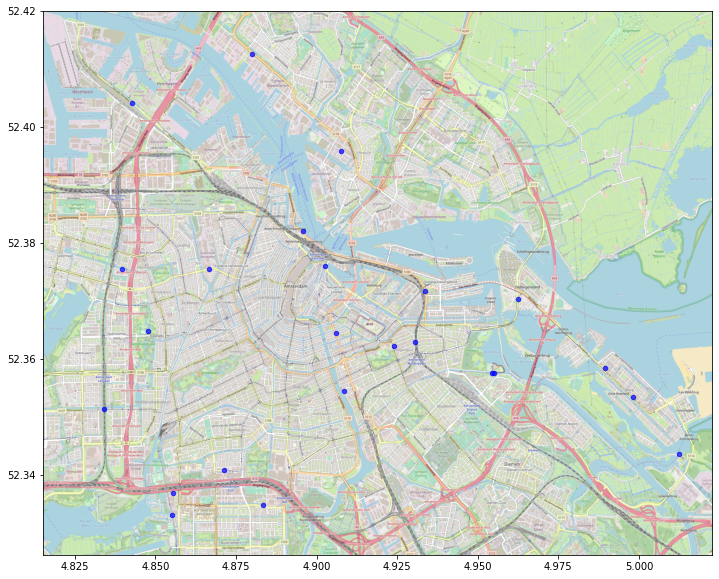

In [48]:
fig, ax = plt.subplots(figsize = (12,10))
ax.scatter(bike_locations.Longitude, bike_locations.Latitude, zorder=1, alpha= 0.7, c='b', s=20)
#ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(bounding_box[0],bounding_box[1])
ax.set_ylim(bounding_box[2],bounding_box[3])
ax.imshow(ams_map, zorder=0, extent = bounding_box, aspect= 'auto')

### Agregate bike counter data by location, get average cyclists per hour

In [49]:
##(bikes
##        .groupby(['location', 'latitude', 'longitude', pd.Grouper(key='datetime', freq='1D')])['count']
##        .sum()
##        .reset_index())
##bikes_count = (bikes
##        .groupby(['location'])['count']
##        .sum()
##        .reset_index())
#bikes_count = (bikes
#        .groupby(['location']).agg({'datetime': [np.min,np.max], 'count':'sum'})
#        .reset_index())
#
#bikes_count.columns = ['location','min','max','count']
#bikes_count['max'] = pd.to_datetime(bikes_count['max'], infer_datetime_format=True)
#bikes_count['min'] = pd.to_datetime(bikes_count['min'], infer_datetime_format=True)
#bikes_count['time_diff'] = (bikes_count['max'] - bikes_count['min']).dt.total_seconds() / 3600
#bikes_count['count'] = bikes_count['count']/bikes_count['time_diff']
##bikes_count = bikes_count.drop(['min','max','time_diff'], axis=1)
#bikes_merged = bikes_count.merge(paths, on='location')
##bikes_merged

In [50]:
bikes_count = bikes.copy()
if agg_times:
    bikes_count = (bikes_count
        .groupby([pd.Grouper(key='datetime', freq=agg_period), 'location']).agg({'count':'sum'})
        .reset_index()) 
bikes_count['hour'] = bikes['datetime'].dt.hour
bikes_count['weekday'] = bikes['datetime'].dt.dayofweek
bikes_count = (bikes_count
        .groupby(['location','weekday', 'hour']).agg({'datetime': [np.min,np.max], 'count':'sum'})
        .reset_index())

bikes_count.columns = ['location','weekday','hour','min','max','count']
bikes_count['max'] = pd.to_datetime(bikes_count['max'], infer_datetime_format=True)
bikes_count['min'] = pd.to_datetime(bikes_count['min'], infer_datetime_format=True)
bikes_count['time_diff'] = (bikes_count['max'] - bikes_count['min']).dt.days / 7
bikes_count['count'] = bikes_count['count']/bikes_count['time_diff']
bikes_count = bikes_count[bikes_count['time_diff']>0]
#bikes_count = bikes_count.drop(['min','max','time_diff'], axis=1)
bikes_count
bikes_merged = bikes_count.merge(paths, on='location')
bikes_merged

,location,weekday,hour,min,max,count,time_diff,osm_reference_id,separated
0,De Boelelaan,0,0,2021-05-11 00:00:00,2022-02-07 00:00:00,17.011029,38.857143,116819461,True
1,De Boelelaan,0,1,2021-06-27 12:00:00,2022-07-07 18:00:00,40.170667,53.571429,116819461,True
2,De Boelelaan,0,2,2021-05-22 00:00:00,2022-08-04 12:00:00,59.667426,62.714286,116819461,True
3,De Boelelaan,0,3,2021-07-08 12:00:00,2023-01-15 00:00:00,54.183784,79.285714,116819461,True
4,De Boelelaan,0,4,2021-06-02 00:00:00,2022-07-21 06:00:00,22.149758,59.142857,116819461,True
...,...,...,...,...,...,...,...,...,...
3969,Zuiderzeeweg,6,19,2021-05-07 00:00:00,2022-02-03 00:00:00,36.775735,38.857143,39402161,True
3970,Zuiderzeeweg,6,20,2021-06-23 12:00:00,2021-09-15 12:00:00,327.500000,12.000000,39402161,True
3971,Zuiderzeeweg,6,21,2021-05-18 00:00:00,2022-03-17 06:00:00,610.132013,43.285714,39402161,True
3972,Zuiderzeeweg,6,22,2021-07-04 12:00:00,2022-06-01 06:00:00,430.616314,47.285714,39402161,True


In [51]:
strava

,edge_uid,activity_type,hour,total_trip_count,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,...,reverse_35_54_people_count,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed,osm_reference_id,ride_count,ebike_ride_count
0,139179989,"Ride,EBikeRide",2021-01-29 13:00:00,5,5,0,5,0,0,0,...,0,0,0,0,0,6.58,0.00,7384649,0,0
1,139179989,"Ride,EBikeRide",2021-01-02 12:00:00,5,5,0,5,0,0,0,...,0,0,0,0,0,7.78,0.00,7384649,5,0
2,139181294,"Ride,EBikeRide",2021-01-27 16:00:00,5,0,5,0,5,0,0,...,0,0,0,0,0,0.00,5.62,326103965,5,0
3,139208215,"Ride,EBikeRide",2021-01-24 13:00:00,5,0,5,0,5,0,0,...,0,0,0,0,0,0.00,2.14,891036876,5,0
4,139220696,"Ride,EBikeRide",2021-01-24 12:00:00,5,0,5,0,5,0,0,...,0,0,0,0,0,0.00,0.22,187079146,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701314,139573322,"Ride,EBikeRide",2021-01-22 16:00:00,5,5,0,5,0,0,0,...,0,0,0,0,0,6.52,0.00,27419638,5,0
701315,139786276,"Ride,EBikeRide",2021-01-03 13:00:00,5,5,0,5,0,0,0,...,0,0,0,0,0,6.15,0.00,119428479,5,0
701316,139786276,"Ride,EBikeRide",2021-01-10 14:00:00,5,5,0,5,0,0,0,...,0,0,0,0,0,5.67,0.00,119428479,5,0
701317,139786276,"Ride,EBikeRide",2021-01-02 12:00:00,5,5,0,5,0,0,0,...,0,0,0,0,0,5.53,0.00,119428479,5,0


### Agg Strava data per street, get hourly cyclist count

In [32]:
strava_count = pd.read_csv('strava_counters_year.csv')
strava_count['hour'] = pd.to_datetime(strava_count['hour'])
def strava_week_transform(strava_dates):
    strava_dates['hour'] = pd.to_datetime(strava_dates['hour'], infer_datetime_format=True)
    strava_dates = strava_dates.rename(columns={'hour':'datetime'})
    strava_dates['hour'] = strava_dates['datetime'].dt.hour
    strava_dates['weekday'] = strava_dates['datetime'].dt.dayofweek
    return strava_dates

if agg_times:
    strava_count = (strava_count
        .groupby([pd.Grouper(key='hour', freq=agg_period), 'osm_reference_id']).agg({'total_trip_count':['sum', 'count']})
        .reset_index()) 
    print(strava_count.columns)
    strava_count.columns = ['hour', 'osm_reference_id','total_trip_count', 'count']

strava_count = strava_week_transform(strava_count)
min_date = strava_count['datetime'].min()
max_date = strava_count['datetime'].max()

print(min_date)
print(max_date)

if agg_times:
    strava_count = (strava_count
            .groupby(['osm_reference_id', 'weekday', 'hour']).agg({'total_trip_count':'sum', 'count':'sum'})
            .reset_index())
else:
    strava_count = (strava_count
            .groupby(['osm_reference_id', 'weekday', 'hour']).agg({'total_trip_count':['sum', 'count']})
            .reset_index())

strava_count.columns = ['osm_reference_id','weekday','hour','count', 'strava_occurances']
time_diff_strava = (max_date - min_date).days / 7  # 52
strava_count['count_adj'] = (strava_count['count'] + (time_diff_strava - strava_count['strava_occurances']) * 2) / time_diff_strava 

strava_count

MultiIndex([(            'hour',      ''),
            ('osm_reference_id',      ''),
            ('total_trip_count',   'sum'),
            ('total_trip_count', 'count')],
           )
2021-12-01 06:00:00
2022-11-30 18:00:00


,osm_reference_id,weekday,hour,count,strava_occurances,count_adj
0,7039639,0,6,1555,142,26.442308
1,7039639,0,12,2450,206,41.192308
2,7039639,0,18,1265,85,23.057692
3,7039639,1,6,1580,167,25.961538
4,7039639,1,12,2400,221,39.653846
...,...,...,...,...,...,...
467,218731396,5,12,440,87,7.115385
468,218731396,5,18,55,11,2.634615
469,218731396,6,6,300,50,5.846154
470,218731396,6,12,520,102,8.076923


### Compare bike counters and strava data, get ratio

In [55]:
final_counts = bikes_merged.merge(strava_count, on=['osm_reference_id', 'weekday','hour'])
final_counts['ratio'] = final_counts['count_x'] / final_counts['count_adj']
final_counts
#final_counts[(final_counts['weekday']==1) & (final_counts['hour']==6)]

,location,weekday,hour,min,max,count_x,time_diff,osm_reference_id,separated,count_y,strava_occurances,count_adj,ratio
0,De Boelelaan,0,6,2021-06-13 00:00:00,2022-07-04 12:00:00,37.448187,55.142857,116819461,True,360,68,6.307692,5.936908
1,De Boelelaan,0,12,2021-05-11 06:00:00,2022-06-20 00:00:00,22.108911,57.714286,116819461,True,195,38,4.288462,5.155441
2,De Boelelaan,0,18,2021-05-26 00:00:00,2022-08-12 12:00:00,33.767494,63.285714,116819461,True,220,42,4.615385,7.316290
3,De Boelelaan,1,6,2021-05-08 00:00:00,2022-07-28 12:00:00,31.829596,63.714286,116819461,True,545,90,9.019231,3.529081
4,De Boelelaan,1,12,2021-06-10 00:00:00,2022-07-25 06:00:00,44.646341,58.571429,116819461,True,285,53,5.442308,8.203568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,Zuiderzeeweg,5,18,2021-05-13 18:00:00,2021-08-05 18:00:00,336.416667,12.000000,39402161,True,195,36,4.365385,77.064611
463,Zuiderzeeweg,6,0,2021-05-28 12:00:00,2021-09-07 18:00:00,450.607843,14.571429,39402161,True,30,2,2.500000,180.243137
464,Zuiderzeeweg,6,6,2021-06-30 12:00:00,2021-09-22 12:00:00,327.083333,12.000000,39402161,True,5195,195,94.403846,3.464725
465,Zuiderzeeweg,6,12,2021-05-10 12:00:00,2022-02-06 12:00:00,135.625000,38.857143,39402161,True,4115,245,71.711538,1.891258


In [56]:
#final_counts.map(lambda x: np.average(x.ratio, weights=x.strava_occurances))
final_coe = sum(final_counts['ratio'] * final_counts['strava_occurances'] ) / final_counts['strava_occurances'].sum()
final_coe

13.606977127713872

In [57]:
strava_coe_table = (final_counts
        .groupby(['weekday', 'hour']).agg({'count_x':'sum','count_adj':'sum','strava_occurances':'sum'})
        .reset_index())
strava_coe_table['ratio'] = strava_coe_table['count_x'] / strava_coe_table['count_adj']
strava_coe_table = strava_coe_table.drop(columns=['count_x', 'count_adj', 'strava_occurances'])
strava_coe_table

,weekday,hour,ratio
0,0,6,16.026722
1,0,12,17.976291
2,0,18,19.389537
3,1,0,336.181910
4,1,6,12.192572
5,1,12,18.449993
6,1,18,9.960744
7,2,0,100.872450
8,2,6,13.473785
9,2,12,18.303096


### Compare accuracy of strava estimation to ground truth

404.9795912628346
1402.6365033032778
0.5647905648321616


C:\Users\Duxiangyu\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='datetime'>

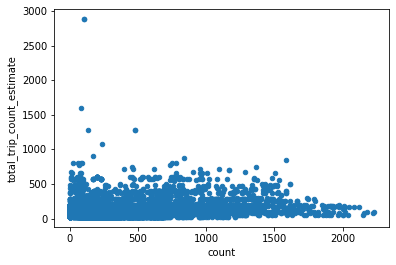

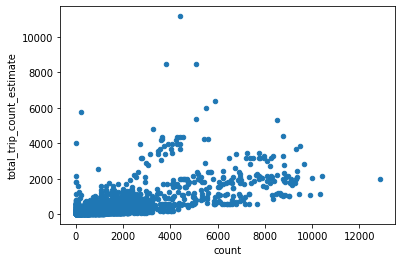

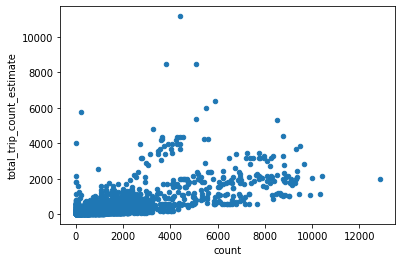

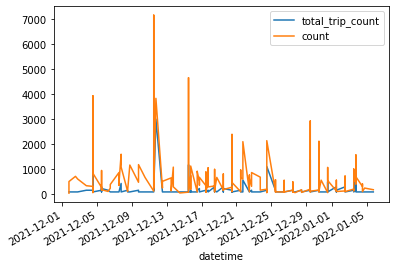

In [58]:
strava_test = pd.read_csv('strava_counters_year.csv')
bikes_loc = bikes.merge(paths, on='location')
bikes_loc = (bikes_loc
        .groupby(['datetime', 'location', 'osm_reference_id']).agg({'count':'sum'})
        .reset_index())

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
#strava_og_test = strava_test.merge(bikes_loc, on=['datetime', 'osm_reference_id'])

strava_test = strava_week_transform(strava_test)
strava_test = strava_test.merge(strava_coe_table, on=['weekday', 'hour'])
strava_test['total_trip_count_estimate'] = strava_test['total_trip_count'] * strava_test['ratio']

strava_test = strava_test.merge(bikes_loc, on=['datetime', 'osm_reference_id'])
strava_test_daily = (strava_test
        .groupby([pd.Grouper(key='datetime', freq='6H'), 'location']).agg({'count':'sum', 
                    'total_trip_count_estimate':'sum', 'total_trip_count':'sum'})
        .reset_index())
strava_test_daily = strava_test_daily[strava_test_daily['total_trip_count_estimate'] < 240000]
strava_test_6h = (strava_test
        .groupby([pd.Grouper(key='datetime', freq='1H'), 'location']).agg({'count':'sum', 
                    'total_trip_count_estimate':'sum', 'total_trip_count':'sum'})
        .reset_index())
print(((strava_test['total_trip_count_estimate'] - strava_test['count']) ** 2).mean() ** .5)
#print(r2_score(strava_test['count'], strava_test['total_trip_count']))

print(((strava_test_daily['total_trip_count_estimate'] - strava_test_daily['count']) ** 2).mean() ** .5)
#print(r2_score(strava_test_daily['count'], strava_test_daily['total_trip_count']))

reg = LinearRegression().fit((strava_test_daily['count']).to_numpy().reshape(-1, 1), strava_test_daily['total_trip_count'])
sc = reg.score((strava_test_daily['count']).to_numpy().reshape(-1, 1), strava_test_daily['total_trip_count'])
print(sc)

strava_test = strava_test[['datetime','location','total_trip_count_estimate', 'count']]
strava_test

strava_test.plot(kind='scatter', x='count', y='total_trip_count_estimate')
strava_test_daily.plot(kind='scatter', x='count', y='total_trip_count_estimate')
strava_test_6h.plot(kind='scatter', x='count', y='total_trip_count_estimate')
strava_test_daily = strava_test_daily[strava_test_daily['datetime'] < pd.Timestamp('2022-01-06')]
#strava_test_daily.plot.line(x='datetime')
strava_test_daily = strava_test_daily[['datetime', 'total_trip_count', 'count']]
strava_test_daily['total_trip_count'] = strava_test_daily['total_trip_count'] * final_coe
strava_test_daily.plot.line(x='datetime')
#strava_test_daily['diff'] = strava_test_daily['total_trip_count'] - strava_test_daily['count']
#strava_test_daily.plot.line(x='datetime', y='diff')
#strava_test_daily

### Adjust january 2021 strava data based on coeficient.

In [59]:
strava_dates_extra = strava_week_transform(strava)
strava_coe_adjusted = strava_dates_extra.merge(strava_coe_table, on=['weekday', 'hour'])
strava_coe_adjusted['total_trip_count'] = strava_coe_adjusted['total_trip_count'] * strava_coe_adjusted['ratio']
#strava_coe_adjusted['reliability'] = strava_coe_adjusted['strava_occurances'] / time_diff_strava
#strava_coe_adjusted['total_trip_count'] = strava_coe_adjusted['total_trip_count'] * (strava_coe_adjusted['ratio']
#* strava_coe_adjusted['reliability'] + (1-strava_coe_adjusted['reliability']) * final_coe)


strava_coe_adjusted = strava_coe_adjusted.drop(columns=['hour', 'weekday'])
strava_coe_adjusted = strava_coe_adjusted.rename(columns={'datetime':'hour'})
strava_coe_adjusted

,edge_uid,activity_type,hour,total_trip_count,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,...,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed,osm_reference_id,ride_count,ebike_ride_count,ratio
0,139179989,"Ride,EBikeRide",2021-01-02 12:00:00,27.081070,5,0,5,0,0,0,...,0,0,0,0,7.78,0.00,7384649,5,0,5.416214
1,139573576,"Ride,EBikeRide",2021-01-23 12:00:00,27.081070,5,0,5,0,0,0,...,0,0,0,0,5.78,0.00,7040827,5,0,5.416214
2,139573576,"Ride,EBikeRide",2021-01-30 12:00:00,27.081070,5,0,5,0,0,0,...,0,0,0,0,4.37,0.00,7040827,5,0,5.416214
3,139573576,"Ride,EBikeRide",2021-01-09 12:00:00,108.324279,10,10,10,10,0,0,...,0,0,0,0,4.78,4.17,7040827,20,0,5.416214
4,139573576,"Ride,EBikeRide",2021-01-02 12:00:00,54.162140,5,0,5,0,0,0,...,0,0,0,0,5.94,0.00,7040827,5,0,5.416214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106532,139224872,"Ride,EBikeRide",2021-01-30 06:00:00,44.095186,5,0,5,0,5,0,...,0,0,0,0,5.20,0.00,7369179,5,0,8.819037
106533,139223521,"Ride,EBikeRide",2021-01-30 06:00:00,44.095186,0,5,0,5,0,5,...,0,0,0,0,0.00,5.54,7369089,5,0,8.819037
106534,139224907,"Ride,EBikeRide",2021-01-30 06:00:00,44.095186,5,0,5,0,5,0,...,0,0,0,0,5.55,0.00,7369179,5,0,8.819037
106535,139224871,"Ride,EBikeRide",2021-01-30 06:00:00,44.095186,5,0,5,0,5,0,...,0,0,0,0,5.89,0.00,7369179,5,0,8.819037


In [60]:
min_date = strava_coe_adjusted['hour'].min()
max_date = strava_coe_adjusted['hour'].max()
time_diff_strava = (max_date - min_date).days *24

strava_street_baseline = (strava_coe_adjusted
        .groupby(['osm_reference_id']).agg({'total_trip_count':['sum', 'count']})
        .reset_index())
strava_street_baseline.columns = ['osm_reference_id','sum','count'] #'baseline'
strava_street_baseline['baseline'] = (strava_street_baseline['sum'] + 
                                       (time_diff_strava - strava_street_baseline['count']) * 1.5) / time_diff_strava
strava_street_baseline = strava_street_baseline[['osm_reference_id', 'baseline']]
strava_street_baseline

,osm_reference_id,baseline
0,4277440,2.863560
1,4305753,3.688625
2,4363637,1.531975
3,4364976,1.861442
4,4371186,1.535529
...,...,...
8876,1020112363,1.599479
8877,1020112365,1.599479
8878,1020112367,1.865942
8879,1020116097,2.364930


### Compare car speed and bike count

In [61]:
#id_speed = strava_name_id.merge(traffic_speed,on='name')
#bikes_speed = id_speed.merge(strava_count,on='osm_reference_id')
#bikes_speed['count'] = bikes_speed['count'] * final_coe
#bikes_speed
bikes_speed = merged_strava_tom.merge(strava_count,on='osm_reference_id')
bikes_speed

,name_tomtom,segmentId,extra_tomtom,geometry,name_strava,osm_reference_id,extra_strava,separated,distance,weekday,hour,count,strava_occurances,count_adj
0,Geldersekade,15280000888622,"{'segmentId': 15280000888622, 'newSegmentId': ...","LINESTRING (4.90155 52.37407, 4.90167 52.37428)",Geldersekade,34140623,"{'cyclestreets_id': '66880', 'highway': 'cycle...",True,2.308174,0,6,545,89,9.057692
1,Geldersekade,15280000888622,"{'segmentId': 15280000888622, 'newSegmentId': ...","LINESTRING (4.90155 52.37407, 4.90167 52.37428)",Geldersekade,34140623,"{'cyclestreets_id': '66880', 'highway': 'cycle...",True,2.308174,0,12,735,106,12.057692
2,Geldersekade,15280000888622,"{'segmentId': 15280000888622, 'newSegmentId': ...","LINESTRING (4.90155 52.37407, 4.90167 52.37428)",Geldersekade,34140623,"{'cyclestreets_id': '66880', 'highway': 'cycle...",True,2.308174,0,18,365,57,6.826923
3,Geldersekade,15280000888622,"{'segmentId': 15280000888622, 'newSegmentId': ...","LINESTRING (4.90155 52.37407, 4.90167 52.37428)",Geldersekade,34140623,"{'cyclestreets_id': '66880', 'highway': 'cycle...",True,2.308174,1,6,785,107,12.980769
4,Geldersekade,15280000888622,"{'segmentId': 15280000888622, 'newSegmentId': ...","LINESTRING (4.90155 52.37407, 4.90167 52.37428)",Geldersekade,34140623,"{'cyclestreets_id': '66880', 'highway': 'cycle...",True,2.308174,1,12,860,127,13.653846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Pontanusstraat,15280000447217,"{'segmentId': 15280000447217, 'newSegmentId': ...","LINESTRING (4.93044 52.36117, 4.93044 52.36113...",Pontanusstraat,118691954,"{'highway': 'cycleway', 'lit:indirect': 'yes',...",True,0.000000,5,12,505,101,7.826923
148,Pontanusstraat,15280000447217,"{'segmentId': 15280000447217, 'newSegmentId': ...","LINESTRING (4.93044 52.36117, 4.93044 52.36113...",Pontanusstraat,118691954,"{'highway': 'cycleway', 'lit:indirect': 'yes',...",True,0.000000,5,18,110,22,3.269231
149,Pontanusstraat,15280000447217,"{'segmentId': 15280000447217, 'newSegmentId': ...","LINESTRING (4.93044 52.36117, 4.93044 52.36113...",Pontanusstraat,118691954,"{'highway': 'cycleway', 'lit:indirect': 'yes',...",True,0.000000,6,6,55,11,2.634615
150,Pontanusstraat,15280000447217,"{'segmentId': 15280000447217, 'newSegmentId': ...","LINESTRING (4.93044 52.36117, 4.93044 52.36113...",Pontanusstraat,118691954,"{'highway': 'cycleway', 'lit:indirect': 'yes',...",True,0.000000,6,12,405,81,6.673077


### Convert tomtom date to hourly

In [62]:
from datetime import datetime
from datetime import date, timedelta

day_week_dict = {'MONDAY':1, 'TUESDAY':2, 'WEDNESDAY':3, 'THURSDAY':4, 'FRIDAY':5, 'SATURDAY':6, 'SUNDAY':7}
timesets = []


for timeset in traffic_speed_json[0]['properties']['timeSets']:

    dates = []
    for ranges in timeset['dayToTimeRanges']:
    
        day = day_week_dict[ranges['dayOfWeek']] - 1
        #print(day)
        
        for date_str in ranges['timeRanges']:
        
            #date_str = ranges['timeRanges'][0]
            start, end = date_str.split('-')
            if end == '24:00': end = '00:00'
            
            start_date = datetime.strptime(start, '%H:%M')
            end_date = datetime.strptime(end, '%H:%M')
            #start_date.day = start_date.day + day
            
            
            for week in range(5):
                #d = max(min(week * 7 + day - 3, 31), 1)
                d = week * 7 + day - 3
                if d >= 1 and d<= 31:
                    start_date = start_date.replace(year = 2021, day = d)
                    end_date = end_date.replace(year = 2021, day = d)
                    
                    def hourly_it(start, finish):
                        while finish > start:
                            start = start + timedelta(hours=1)
                            yield start
                                
                    start = start_date#datetime(2018, 10, 2, 12)
                    finish = end_date#datetime(2018, 10, 3, 12)
                    for hour in hourly_it(start, finish):
                        #print(hour)
                        dates.append(hour)
    #print(dates)
    timesets.append(dates)
print(len(timesets))

10


In [63]:
traffic_speed_expanded = None
traffic_speed_expanded = pd.read_csv('big.csv')

In [64]:
def extra_to_speed_list(x):
    return list(map(lambda y: y['averageSpeed'], x['segmentTimeResults']))
def speed_list_expand(speed_list):
    out = []
    for i, speed in enumerate(speed_list):
        for time in timesets[i]:
            out.append({time: speed})
    return out


if traffic_speed_expanded is None:
    traffic_speed_expanded = traffic_speed.copy()
    #traffic_speed_expanded = traffic_speed_expanded.drop(columns=['speed'])
    traffic_speed_expanded['extra'] = traffic_speed_expanded['extra'].apply(extra_to_speed_list)
    traffic_speed_expanded['extra'] = traffic_speed_expanded['extra'].apply(speed_list_expand)
    traffic_speed_expanded = traffic_speed_expanded.explode('extra')
    traffic_speed_expanded['Variant'] = traffic_speed_expanded['extra'].apply(lambda x: list(x.keys()))
    traffic_speed_expanded['Price'] = traffic_speed_expanded.pop('extra').apply(lambda x: list(x.values()))
    traffic_speed_expanded = traffic_speed_expanded.explode(['Variant', 'Price'])#.reset_index(drop=True)
    traffic_speed_expanded = traffic_speed_expanded.drop(columns=['geometry'])
traffic_speed_expanded['Variant'] = pd.to_datetime(traffic_speed_expanded['Variant'], infer_datetime_format=True)

#pd.concat(traffic_speed_expanded['extra'].apply(pd.DataFrame).tolist(),keys=traffic_speed_expanded["name"]).reset_index(level="name")
traffic_speed_expanded

,Unnamed: 0,Unnamed: 0.1,name,segmentId,Variant,Price
0,0,0,Louis Couperusstraat,-15280001772950,2021-01-04 10:00:00,24.83
1,1,0,Louis Couperusstraat,-15280001772950,2021-01-04 11:00:00,24.83
2,2,0,Louis Couperusstraat,-15280001772950,2021-01-04 12:00:00,24.83
3,3,0,Louis Couperusstraat,-15280001772950,2021-01-04 13:00:00,24.83
4,4,0,Louis Couperusstraat,-15280001772950,2021-01-04 14:00:00,24.83
...,...,...,...,...,...,...
14275619,14275619,20931,Cornelis Lelylaan,15280002369161,2021-01-24 21:00:00,48.91
14275620,14275620,20931,Cornelis Lelylaan,15280002369161,2021-01-24 22:00:00,48.91
14275621,14275621,20931,Cornelis Lelylaan,15280002369161,2021-01-31 20:00:00,48.91
14275622,14275622,20931,Cornelis Lelylaan,15280002369161,2021-01-31 21:00:00,48.91


### Merge tomtom data with strava

In [65]:
#traffic_speed_expanded = traffic_speed_expanded.drop(columns=['geometry'])
traffic_streets = traffic_speed_expanded.merge(merged_strava_tom, how='inner', on='segmentId')
traffic_streets = traffic_streets[['name', 'segmentId', 'Variant', 'Price', 'geometry', 'osm_reference_id', 'separated']]
#segmentId
traffic_streets

,name,segmentId,Variant,Price,geometry,osm_reference_id,separated
0,Burgemeester Fockstraat,-15280000018857,2021-01-04 10:00:00,24.43,"LINESTRING (4.83330 52.38231, 4.83354 52.38284)",323258133,True
1,Burgemeester Fockstraat,-15280000018857,2021-01-04 11:00:00,24.43,"LINESTRING (4.83330 52.38231, 4.83354 52.38284)",323258133,True
2,Burgemeester Fockstraat,-15280000018857,2021-01-04 12:00:00,24.43,"LINESTRING (4.83330 52.38231, 4.83354 52.38284)",323258133,True
3,Burgemeester Fockstraat,-15280000018857,2021-01-04 13:00:00,24.43,"LINESTRING (4.83330 52.38231, 4.83354 52.38284)",323258133,True
4,Burgemeester Fockstraat,-15280000018857,2021-01-04 14:00:00,24.43,"LINESTRING (4.83330 52.38231, 4.83354 52.38284)",323258133,True
...,...,...,...,...,...,...,...
4896755,Distelweg,15280002438902,2021-01-24 21:00:00,34.61,"LINESTRING (4.90208 52.39397, 4.90173 52.39410)",110398964,False
4896756,Distelweg,15280002438902,2021-01-24 22:00:00,34.61,"LINESTRING (4.90208 52.39397, 4.90173 52.39410)",110398964,False
4896757,Distelweg,15280002438902,2021-01-31 20:00:00,34.61,"LINESTRING (4.90208 52.39397, 4.90173 52.39410)",110398964,False
4896758,Distelweg,15280002438902,2021-01-31 21:00:00,34.61,"LINESTRING (4.90208 52.39397, 4.90173 52.39410)",110398964,False


In [66]:
strava_before_merge = strava_coe_adjusted[['hour', 'osm_reference_id', 'total_trip_count', 'ratio']]
strava_before_merge.loc['hour'] = pd.to_datetime(strava_before_merge['hour'], infer_datetime_format=True)
strava_before_merge

C:\Users\Duxiangyu\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,hour,osm_reference_id,total_trip_count,ratio
0,2021-01-02 12:00:00,7384649,27.08107,5.416214
1,2021-01-23 12:00:00,7040827,27.08107,5.416214
2,2021-01-30 12:00:00,7040827,27.08107,5.416214
3,2021-01-09 12:00:00,7040827,108.324279,5.416214
4,2021-01-02 12:00:00,7040827,54.16214,5.416214
...,...,...,...,...
106533,2021-01-30 06:00:00,7369089,44.095186,8.819037
106534,2021-01-30 06:00:00,7369179,44.095186,8.819037
106535,2021-01-30 06:00:00,7369179,44.095186,8.819037
106536,2021-01-30 06:00:00,7369179,44.095186,8.819037


In [67]:
print(len(strava_before_merge))
print(len(traffic_streets))
final_merge = pd.merge(strava_before_merge, traffic_streets,  how='inner', left_on=['osm_reference_id','hour'], right_on = ['osm_reference_id','Variant'])
#final_merge = final_merge.drop(columns=['speed','extra_tomtom', 'extra_strava','distance','name_strava','Variant','name_tomtom'])
#final_merge = final_merge.drop(columns=['extra_tomtom', 'extra_strava','distance','name_strava','name_tomtom', 'Variant'])
final_merge = final_merge.rename(columns={'Price':'car_speed', 'hour':'datetime', 'total_trip_count':'bike_count'})
#final_merge = final_merge['bike_count'].fillna(final_merge['ratio'])
#final_merge[datetime]
print(len(final_merge))

weather_mod = weather.drop(columns=['name', 'Unnamed: 0', 'conditions'])
weather_mod['datetime'] = pd.to_datetime(weather_mod['datetime'], infer_datetime_format=True)
final_merge = final_merge.merge(weather_mod, on='datetime')
final_merge = final_merge.rename(columns={'tier':'weather_condition'})

final_merge = final_merge.merge(strava_street_baseline, on='osm_reference_id')
final_merge = final_merge[['datetime','osm_reference_id','bike_count','name','car_speed','geometry','separated','weather_condition','baseline']]


final_merge = final_merge[final_merge['car_speed']!=0]

final_merge

106538
4896760
58188


,datetime,osm_reference_id,bike_count,name,car_speed,geometry,separated,weather_condition,baseline
0,2021-01-02 12:00:00,322879033,27.08107,Heemstedestraat,24.36,"LINESTRING (4.84848 52.35155, 4.84920 52.35156)",True,4,1.535529
1,2021-01-02 12:00:00,322879033,27.08107,Heemstedestraat,18.69,"LINESTRING (4.84920 52.35156, 4.84927 52.35155...",True,4,1.535529
2,2021-01-02 12:00:00,112515073,27.08107,Panamalaan,36.79,"LINESTRING (4.93375 52.36738, 4.93376 52.36713)",False,4,1.571059
3,2021-01-02 12:00:00,112515073,27.08107,Panamalaan,36.18,"LINESTRING (4.93374 52.36746, 4.93375 52.36738)",False,4,1.571059
4,2021-01-09 12:00:00,112515073,27.08107,Panamalaan,36.79,"LINESTRING (4.93375 52.36738, 4.93376 52.36713)",False,4,1.571059
...,...,...,...,...,...,...,...,...,...
58183,2021-01-23 18:00:00,38316248,192.538467,Oude Hoogstraat,24.11,"LINESTRING (4.89852 52.37105, 4.89862 52.37103)",False,4,1.765331
58184,2021-01-23 18:00:00,38316248,192.538467,Oude Hoogstraat,22.96,"LINESTRING (4.89862 52.37103, 4.89871 52.37100)",False,4,1.765331
58185,2021-01-25 18:00:00,98500925,96.947683,Contactweg,35.16,"LINESTRING (4.85554 52.39057, 4.85554 52.39061...",False,4,1.632566
58186,2021-01-25 18:00:00,98500925,96.947683,Contactweg,43.02,"LINESTRING (4.85518 52.39165, 4.85522 52.39047)",False,4,1.632566


In [68]:
final_merge.to_csv('final_dataframe.csv')

In [35]:
# final_geo = gpd.GeoDataFrame(final_merge,geometry=final_merge['geometry'].apply(shapely.geometry.shape), crs={'init':'EPSG:4326'})
# final_geo['datetime'] = final_geo['datetime'].astype(str)
# with open("final.geojson", "w", encoding="utf-8") as outfile:
#     outfile.write(final_geo.to_json())

In [ ]:
#n=3000
##split DataFrame into chunks
#small_geo = final_geo[['name','geometry']]
#list_df = [small_geo[i:i+n] for i in range(0,len(small_geo),n)]
#print(len(list_df))
#sub_merge = []
#for df in list_df:
#    ret = df.dissolve(by='name')
#    sub_merge.append(ret)
#merged_geo = pd.concat(sub_merge)
#merged_geo = merged_geo.dissolve(by='name')
#merged_geo

In [ ]:
#merged_geo_1 = merged_geo.merge(final_geo, on='name', how='inner')
#merged_geo_1['geometry'] = merged_geo_1['geometry_x']
#merged_geo_1 = merged_geo_1[['datetime','osm_reference_id','bike_count','name','car_speed','geometry','separated','weather_condition','baseline']]
##merged_geo_1['geometry'] = merged_geo_1['geometry'].astype(str)
#merged_geo_1 = (merged_geo_1
#        .groupby(['name', 'separated']).agg({'baseline':'mean',  'geometry':'first'})
#        .reset_index())
#merged_geo_1 = gpd.GeoDataFrame(merged_geo_1,geometry=merged_geo_1['geometry'], crs={'init':'EPSG:4326'})
#merged_geo_1

In [ ]:
##merged_geo_1.to_file("final_merged_street.shp")
#with open("final_merged_street.geojson", "w", encoding="utf-8") as outfile:
#    outfile.write(merged_geo_1.to_json())

### OPTIONAL: check correlation between variables

In [ ]:
strava_hour = (strava_coe_adjusted
        .groupby(['hour']).agg({'total_trip_count':['sum', 'count']})
        .reset_index())
strava_hour.columns = ['datetime','count', 'strava_occurances']
strava_weather = strava_hour.merge(weather_mod, on='datetime')
strava_weather = strava_weather.drop(columns=['Wind_Cond', 'Precip_Cond', 'tier'])
#strava_weather['precip'].corr(strava_weather['count'], method='pearson')
strava_weather.corr(method='pearson')
#strava_weather

In [ ]:
strava_week = (strava
        .groupby([strava['hour'].dt.dayofweek]).agg({'total_trip_count':['sum', 'count']})
        .reset_index())
strava_week.columns = ['datetime','count', 'strava_occurances']
strava_week.corr(method='pearson')

In [ ]:
bikes_speed_filtered = final_merge#final_merge[final_merge['strava_occurances'] > 20]
#bikes_speed_filtered = bikes_speed_filtered[bikes_speed_filtered['count'] > 5]
bikes_speed_filtered = bikes_speed_filtered.groupby(['name']).agg({'car_speed': 'mean', 'bike_count':'mean'}).reset_index(0)
plt.scatter(bikes_speed_filtered['car_speed'], bikes_speed_filtered['bike_count'])
#bikes_speed_filtered.plot(x='speed', y='count',kind='scatter')
plt.ylabel('Cyclists per hour')
plt.show()